# Starbucks offers: Advanced customer segmentation with Python


# Dataset

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [ ]:
!pip install lifetimes #For RFM Model
!pip install -U yellowbrick #For elbow method visualisation

Requirement already up-to-date: yellowbrick in /usr/local/lib/python3.6/dist-packages (1.1)


In [ ]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
import plotly.express as px
% matplotlib inline

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

from yellowbrick.cluster.elbow import kelbow_visualizer

from lifetimes.utils import summary_data_from_transaction_data

In [ ]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Data wrangling

### Exploration

In [ ]:
print(portfolio.shape)
portfolio.head()

(10, 6)


reward  ...                                id
0      10  ...  ae264e3637204a6fb9bb56bc8210ddfd
1      10  ...  4d5c57ea9a6940dd891ad53e9dbe8da0
2       0  ...  3f207df678b143eea3cee63160fa8bed
3       5  ...  9b98b8c7a33c4b65b9aebfe6a799e6d9
4       5  ...  0b1e1539f2cc45b7b9fa7c272da2e1d7

[5 rows x 6 columns]

In [ ]:
print(profile.shape)
profile.head()

(17000, 5)


gender  age                                id  became_member_on    income
0   None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212       NaN
1      F   55  0610b486422d4921ae7d2bf64640c50b          20170715  112000.0
2   None  118  38fe809add3b4fcf9315a9694bb96ff5          20180712       NaN
3      F   75  78afa995795e4d85b5d9ceeca43f5fef          20170509  100000.0
4   None  118  a03223e636434f42ac4c3df47e8bac43          20170804       NaN

In [ ]:
print(transcript.shape)
transcript.head()

(306534, 4)


person  ... time
0  78afa995795e4d85b5d9ceeca43f5fef  ...    0
1  a03223e636434f42ac4c3df47e8bac43  ...    0
2  e2127556f4f64592b11af22de27a7932  ...    0
3  8ec6ce2a7e7949b1bf142def7d0e0586  ...    0
4  68617ca6246f4fbc85e91a2a49552598  ...    0

[5 rows x 4 columns]

In [ ]:
# convert dates to Datetime
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

# fill empty genders
profile['gender'] = profile['gender'].fillna('NA')

print('Unique genders:')
print(profile['gender'].unique())

print('\nDescriptive stats for age and income:')
print(profile.describe())

Unique genders:
['NA' 'F' 'M' 'O']

Descriptive stats for age and income:
                age         income
count  17000.000000   14825.000000
mean      62.531412   65404.991568
std       26.738580   21598.299410
min       18.000000   30000.000000
25%       45.000000   49000.000000
50%       58.000000   64000.000000
75%       73.000000   80000.000000
max      118.000000  120000.000000


In [ ]:
transcript.query('event == "transaction"').head(1)

person  ... time
12654  02c083884c7d45b39cc68e1314fec56c  ...    0

[1 rows x 4 columns]

In [ ]:
transcript.query('event == "offer received"').head(1)

person  ... time
0  78afa995795e4d85b5d9ceeca43f5fef  ...    0

[1 rows x 4 columns]

In [ ]:
transcript.query('event == "offer viewed"').head(1)

person  ... time
12650  389bc3fa690240e798340f5a15918d5c  ...    0

[1 rows x 4 columns]

In [ ]:
transcript.query('event == "offer completed"')['value'].iloc[0]

{'offer_id': '2906b810c7d4411798c6938adc9daaa5', 'reward': 2}

In [ ]:
print('Unique event types:')
print(transcript['event'].unique())

print('\nDescriptive stats for time:')
print(transcript.describe())

Unique event types:
['offer received' 'offer viewed' 'transaction' 'offer completed']

Descriptive stats for time:
                time
count  306534.000000
mean      366.382940
std       200.326314
min         0.000000
25%       186.000000
50%       408.000000
75%       528.000000
max       714.000000


### Impute income

In [ ]:
profile['income_na'] = profile['income'].isna().astype(int)
profile['income'] = profile['income'].fillna(profile['income'].mean())

### One-hot encoding

In [ ]:
# channel dummies
mlb = MultiLabelBinarizer()
channel_dummies = pd.DataFrame(mlb.fit_transform(portfolio['channels']), columns=mlb.classes_, index=portfolio.index)

# offer type dummies
offer_type_dummies = portfolio['offer_type'].str.get_dummies()

portfolio = pd.concat([portfolio, channel_dummies, offer_type_dummies], axis=1)

#portfolio.drop(['channels', 'offer_type'], axis=1, inplace=True)

portfolio.head()

reward                      channels  ...  discount  informational
0      10       [email, mobile, social]  ...         0              0
1      10  [web, email, mobile, social]  ...         0              0
2       0          [web, email, mobile]  ...         0              1
3       5          [web, email, mobile]  ...         0              0
4       5                  [web, email]  ...         1              0

[5 rows x 13 columns]

In [ ]:
# gender type dummies
profile['year_joined'] = profile['became_member_on'].apply(lambda x: str(x.year))

gender_dummies = profile['gender'].str.get_dummies().add_prefix('gender_')
year_joined_dummies = profile['year_joined'].str.get_dummies().add_prefix('year_joined_')

profile = pd.concat([profile, gender_dummies, year_joined_dummies], axis=1)

#profile.drop(['gender'], axis=1, inplace=True)
profile.drop(['became_member_on'], axis=1, inplace=True)
profile.drop(['year_joined'], axis=1, inplace=True)

profile.head()

gender  age  ... year_joined_2017  year_joined_2018
0     NA  118  ...                1                 0
1      F   55  ...                1                 0
2     NA  118  ...                0                 1
3      F   75  ...                1                 0
4     NA  118  ...                1                 0

[5 rows x 15 columns]

In [ ]:
# event dummies
event_dummies = transcript['event'].str.get_dummies()
event_dummies.drop('transaction', axis=1, inplace=True)

transcript = pd.concat([transcript, event_dummies], axis=1)
transcript.rename(columns={'offer completed': 'offer_completed', 'offer received': 'offer_received', 'offer viewed': 'offer_viewed'}, inplace=True)

#profile.drop(['event'], axis=1, inplace=True)

transcript.head()

person  ... offer_viewed
0  78afa995795e4d85b5d9ceeca43f5fef  ...            0
1  a03223e636434f42ac4c3df47e8bac43  ...            0
2  e2127556f4f64592b11af22de27a7932  ...            0
3  8ec6ce2a7e7949b1bf142def7d0e0586  ...            0
4  68617ca6246f4fbc85e91a2a49552598  ...            0

[5 rows x 7 columns]

### Split offer and transaction dataframes


In [ ]:
transactions = transcript.query('event == "transaction"').copy()
transactions['amount'] = transactions['value'].apply(lambda x: list(x.values())[0])
transactions.drop(['value', 'offer_completed', 'offer_received', 'offer_viewed'], axis=1, inplace=True)

offers = transcript.query('event != "transaction"').copy()
offers['offer_id'] = offers['value'].apply(lambda x: list(x.values())[0])
offers.drop(['value'], axis=1, inplace=True)

### Merge dataframes

In [ ]:
transcript.head(1)

person  ... offer_viewed
0  78afa995795e4d85b5d9ceeca43f5fef  ...            0

[1 rows x 7 columns]

In [ ]:
portfolio.head(1)

reward                 channels  difficulty  ...  bogo discount informational
0      10  [email, mobile, social]          10  ...     1        0             0

[1 rows x 13 columns]

In [ ]:
profile.head(1)

gender  age  ... year_joined_2017  year_joined_2018
0     NA  118  ...                1                 0

[1 rows x 15 columns]

In [ ]:
offers = offers.merge(profile, left_on='person', right_on='id')
offers = offers.merge(portfolio, left_on='offer_id', right_on='id')
offers.drop(['id_x', 'id_y'], axis=1, inplace=True)
offers.set_index('offer_id', inplace=True)
offers.head(2)

person  ... informational
offer_id                                                            ...              
9b98b8c7a33c4b65b9aebfe6a799e6d9  78afa995795e4d85b5d9ceeca43f5fef  ...             0
9b98b8c7a33c4b65b9aebfe6a799e6d9  78afa995795e4d85b5d9ceeca43f5fef  ...             0

[2 rows x 32 columns]

In [ ]:
transactions = transactions.merge(profile, left_on='person', right_on='id')
transactions.drop(['event'], axis=1, inplace=True)
transactions.head(2)

person  time  ...  year_joined_2017 year_joined_2018
0  02c083884c7d45b39cc68e1314fec56c     0  ...                 0                0
1  02c083884c7d45b39cc68e1314fec56c     6  ...                 0                0

[2 rows x 18 columns]

### Drop outliers

In [ ]:
profile = profile.query('age <= 99')
offers = offers.query('age <= 99')
transactions = transactions.query('age <= 99')

In [ ]:
transactions.describe()

time         amount  ...  year_joined_2017  year_joined_2018
count  123802.000000  123802.000000  ...     123802.000000     123802.000000
mean      381.255941      13.990337  ...          0.355390          0.157744
std       201.815431      31.767386  ...          0.478633          0.364502
min         0.000000       0.050000  ...          0.000000          0.000000
25%       210.000000       3.660000  ...          0.000000          0.000000
50%       402.000000      10.790000  ...          0.000000          0.000000
75%       552.000000      19.120000  ...          1.000000          0.000000
max       714.000000    1062.280000  ...          1.000000          1.000000

[8 rows x 15 columns]

### Repeat offer exposure

In [ ]:
offers.reset_index(inplace=True)

In [ ]:
# the same offer can be received and viewed multiple times
offers[offers.duplicated(subset=['offer_id', 'person'], keep=False)].head()

offer_id  ... informational
0  9b98b8c7a33c4b65b9aebfe6a799e6d9  ...             0
1  9b98b8c7a33c4b65b9aebfe6a799e6d9  ...             0
2  9b98b8c7a33c4b65b9aebfe6a799e6d9  ...             0
3  9b98b8c7a33c4b65b9aebfe6a799e6d9  ...             0
4  9b98b8c7a33c4b65b9aebfe6a799e6d9  ...             0

[5 rows x 33 columns]

In [ ]:
# add receipt, view and completion time columns
offers['time'] = offers['time'] + 0.5
offers['received_time'] = offers['offer_received'] * offers['time']
offers['viewed_time'] = offers['offer_viewed'] * offers['time']
offers['completed_time'] = offers['offer_completed'] * offers['time']
offers.head()

offer_id  ... completed_time
0  9b98b8c7a33c4b65b9aebfe6a799e6d9  ...            0.0
1  9b98b8c7a33c4b65b9aebfe6a799e6d9  ...            0.0
2  9b98b8c7a33c4b65b9aebfe6a799e6d9  ...          132.5
3  9b98b8c7a33c4b65b9aebfe6a799e6d9  ...            0.0
4  9b98b8c7a33c4b65b9aebfe6a799e6d9  ...            0.0

[5 rows x 36 columns]

In [ ]:
# an offer can be received multiple times by the same person
# we'll use first exposure times, but keep track of the number of exposures

offers_mins = offers.groupby(['person', 'offer_id', 'event']).min()
offers_sums = offers.groupby(['person', 'offer_id', 'event'])[['offer_received', 'offer_viewed', 'offer_completed']].sum()

offers_mins.update(offers_sums)

offers_grouped = offers_mins.groupby(['person', 'offer_id']).max().reset_index()

offers_grouped.fillna(0, inplace=True)

offers_grouped.head()

person  ... completed_time
0  0009655768c64bdeb2e877511632db8f  ...          576.5
1  0009655768c64bdeb2e877511632db8f  ...            0.0
2  0009655768c64bdeb2e877511632db8f  ...            0.0
3  0009655768c64bdeb2e877511632db8f  ...          414.5
4  0009655768c64bdeb2e877511632db8f  ...          528.5

[5 rows x 35 columns]

### Drop misattributions

In [ ]:
offers_grouped['end_time'] = offers_grouped['received_time'] + offers_grouped['duration'] * 24
offers_grouped['viewed_on_time'] = offers_grouped.apply(lambda x: 1 if x['viewed_time'] < x['end_time'] and x['viewed_time'] != 0 else 0, axis=1)
offers_grouped['completed_on_time'] = offers_grouped.apply(lambda x: 1 if x['completed_time'] < x['end_time'] and x['completed_time'] != 0 else 0, axis=1)

# dropping misattributions (completion without view, completion before view, or view before receipt)
offers_grouped = offers_grouped.query('~(completed_time > 0 and viewed_time == 0)')
offers_grouped = offers_grouped.query('~(completed_time != 0 and completed_time < viewed_time)')
offers_grouped = offers_grouped.query('~(viewed_time != 0 and viewed_time < received_time)')

### Recency & frequency

In [ ]:
# time to Datetime
transactions['datetime'] = transactions['time'].apply(lambda x: pd.Timestamp('2000-01-01T12') + pd.Timedelta(hours=x))
transactions.head()

rf = summary_data_from_transaction_data(transactions, 'person', 'datetime', monetary_value_col='amount')
rf.drop('T', axis=1, inplace=True)

profile.rename({'id': 'person'}, axis=1, inplace=True)
profile.set_index('person', inplace=True)

customers = profile.join(rf)
customers.head()

gender  age  ...  recency  monetary_value
person                                        ...                         
0610b486422d4921ae7d2bf64640c50b      F   55  ...     21.0       27.750000
78afa995795e4d85b5d9ceeca43f5fef      F   75  ...     16.0       24.320000
e2127556f4f64592b11af22de27a7932      M   68  ...     10.0       18.420000
389bc3fa690240e798340f5a15918d5c      M   65  ...     22.0       13.445000
2eeac8d8feae4a8cad5a6af0499a211d      M   58  ...     15.0        4.433333

[5 rows x 17 columns]

### View & conversion rates

In [ ]:
def sum_greater_than_zero(x):
    """Counts non-0 items."""
    return (x > 0).sum()

def mean_greater_than_zero(x):
    """Average non-0 items."""
    return x.replace(0, np.nan).mean()

# BOGO offers
bogo_performance = offers_grouped.query('offer_type == "bogo"').groupby(['person']).agg(
    offers_received_cnt = ('offer_received', sum_greater_than_zero),
    offers_viewed_cnt = ('offer_viewed', sum_greater_than_zero),
    offers_completed_cnt = ('offer_completed', sum_greater_than_zero),
)
bogo_performance['bogo_vr'] = bogo_performance['offers_viewed_cnt'] / bogo_performance['offers_received_cnt']
bogo_performance['bogo_cr'] = bogo_performance['offers_completed_cnt'] / bogo_performance['offers_viewed_cnt']
bogo_performance.drop(['offers_viewed_cnt', 'offers_received_cnt', 'offers_completed_cnt'], axis=1, inplace=True)

# discount offers
discount_performance = offers_grouped.query('offer_type == "discount"').groupby(['person']).agg(
    offers_received_cnt = ('offer_received', sum_greater_than_zero),
    offers_viewed_cnt = ('offer_viewed', sum_greater_than_zero),
    offers_completed_cnt = ('offer_completed', sum_greater_than_zero),
)
discount_performance['discount_vr'] = discount_performance['offers_viewed_cnt'] / discount_performance['offers_received_cnt']
discount_performance['discount_cr'] = discount_performance['offers_completed_cnt'] / discount_performance['offers_viewed_cnt']
discount_performance.drop(['offers_viewed_cnt', 'offers_received_cnt', 'offers_completed_cnt'], axis=1, inplace=True)

# informational offers view rate
informational_performance = offers_grouped.query('offer_type == "informational"').groupby(['person']).agg(
    offers_received_cnt = ('offer_received', sum_greater_than_zero),
    offers_viewed_cnt = ('offer_viewed', sum_greater_than_zero),
    offers_completed_cnt = ('offer_completed', sum_greater_than_zero),
)
informational_performance['informational_vr'] = informational_performance['offers_viewed_cnt'] / informational_performance['offers_received_cnt']
informational_performance.drop(['offers_viewed_cnt', 'offers_received_cnt', 'offers_completed_cnt'], axis=1, inplace=True)

# all offers conversion rate
total_performance = offers_grouped.query('offer_type != "informational"').groupby(['person']).agg(
    offers_received_cnt = ('offer_received', sum_greater_than_zero),
    offers_viewed_cnt = ('offer_viewed', sum_greater_than_zero),
    offers_completed_cnt = ('offer_completed', sum_greater_than_zero),
)
total_performance['total_cr'] = total_performance['offers_completed_cnt'] / total_performance['offers_viewed_cnt']
total_performance.drop(['offers_viewed_cnt', 'offers_received_cnt', 'offers_completed_cnt'], axis=1, inplace=True)

customers = customers.join(bogo_performance).join(discount_performance).join(informational_performance).join(total_performance)
customers.fillna(0, inplace=True)
customers.head()

gender  age  ...  informational_vr  total_cr
person                                        ...                            
0610b486422d4921ae7d2bf64640c50b      F   55  ...               0.0  0.000000
78afa995795e4d85b5d9ceeca43f5fef      F   75  ...               1.0  1.000000
e2127556f4f64592b11af22de27a7932      M   68  ...               0.0  0.666667
389bc3fa690240e798340f5a15918d5c      M   65  ...               0.0  1.000000
2eeac8d8feae4a8cad5a6af0499a211d      M   58  ...               0.0  0.500000

[5 rows x 23 columns]

### Customer offers

In [ ]:
customer_offers = offers_grouped.groupby('person').agg(
    reward_avg = ('reward', 'mean'),
    difficulty_avg = ('difficulty', 'mean'),
    email_cnt = ('email', 'sum'),
    mobile_cnt = ('mobile', 'sum'),
    social_cnt = ('social', 'sum'),
    web_cnt = ('web', 'sum'),
    bogo_cnt = ('bogo', 'sum'),
    discount_cnt = ('discount', 'sum'),
    informational_cnt = ('informational', 'sum'),
    offers_received_cnt = ('offer_received', sum_greater_than_zero),
    offers_viewed_cnt = ('offer_viewed', sum_greater_than_zero),
    offers_completed_cnt = ('offer_completed', sum_greater_than_zero),
    exposures_received_avg = ('offer_received', 'mean'),
    exposures_viewed_avg = ('offer_viewed', 'mean'),
    exposures_completed_avg = ('offer_completed', 'mean'),
)

customers = customers.join(customer_offers)

customers.drop(['gender', 'gender_NA', 'income_na'], axis=1, inplace=True)
customers.dropna(inplace=True)

customers.head()

age  ...  exposures_completed_avg
person                                 ...                         
0610b486422d4921ae7d2bf64640c50b   55  ...                 0.000000
78afa995795e4d85b5d9ceeca43f5fef   75  ...                 0.666667
e2127556f4f64592b11af22de27a7932   68  ...                 0.500000
389bc3fa690240e798340f5a15918d5c   65  ...                 1.250000
2eeac8d8feae4a8cad5a6af0499a211d   58  ...                 0.333333

[5 rows x 35 columns]

## Exploratory analysis

In [ ]:
starbucks = ["#008248", "#604c4c", "#eac784", "#f0cddb", "#6B9997"]
starbucks_d = ["#cce6da", "#66b491", "#008248"]
genders = ["#8700f9", "#00c4a9", "#4462D1"]

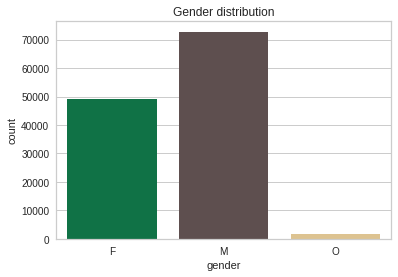

In [ ]:
sns.set_palette(sns.color_palette(starbucks))

df = transactions[['gender', 'age', 'amount', 'income']]

ax = sns.countplot(x='gender', data=df)
ax.set_title('Gender distribution');

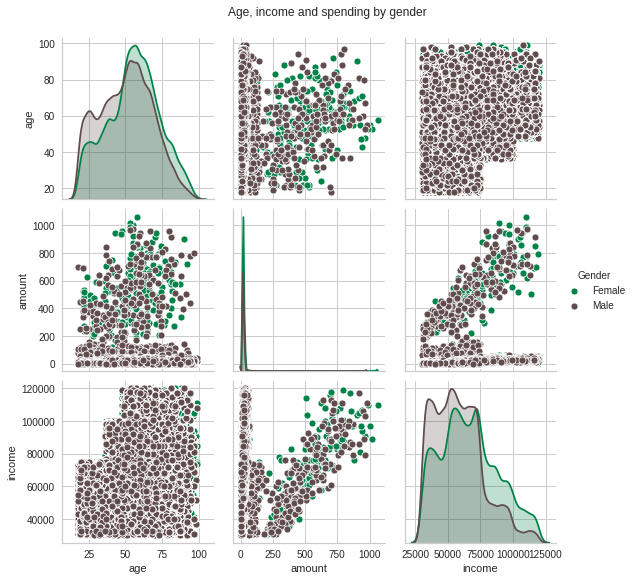

In [ ]:
sns.set_palette(sns.color_palette(starbucks))

df = transactions[['gender', 'age', 'amount', 'income']].query('gender in ["F", "M"]')

df.rename(columns={'gender': 'Gender'}, inplace=True)
df['Gender'] = df['Gender'].map({'M': 'Male', 'F': 'Female'})

g = sns.pairplot(df, hue='Gender')
g.fig.suptitle("Age, income and spending by gender", y=1.05);

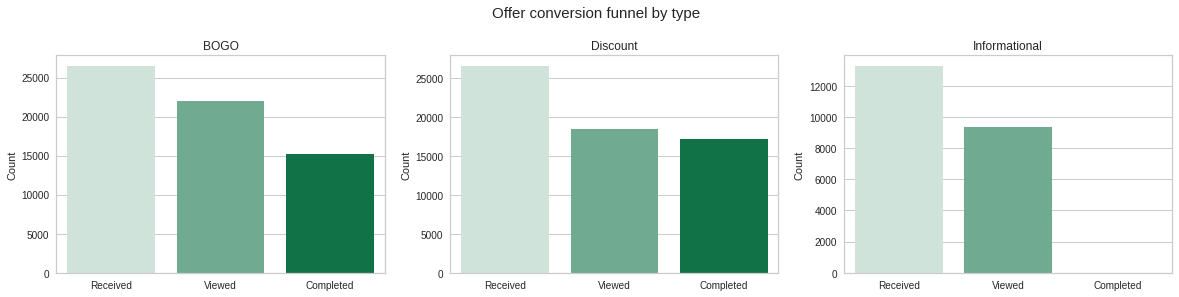

In [ ]:
sns.set_palette(sns.color_palette(starbucks))

df = offers.groupby(['event', 'offer_type'])['person'].count().reset_index()
df['event'] = pd.Categorical(df['event'], ["offer received", "offer viewed", "offer completed"])
df.sort_values('event', inplace=True)

fig, axs = plt.subplots(ncols=3, figsize=(20, 4))

df['event'] = df['event'].map({'offer received': 'Received', 'offer viewed': 'Viewed', 'offer completed': 'Completed'})

ax = sns.barplot('event', y='person', data=df.query('offer_type == "bogo"'), palette=starbucks_d, ci=None, ax=axs[0])
ax.set(xlabel='', ylabel='Count', title='BOGO')

ax = sns.barplot('event', y='person', data=df.query('offer_type == "discount"'), palette=starbucks_d, ci=None, ax=axs[1])
ax.set(xlabel='', ylabel='Count', title='Discount')

ax = sns.barplot('event', y='person', data=df.query('offer_type == "informational"'), palette=starbucks_d, ci=None, ax=axs[2])
ax.set(xlabel='', ylabel='Count', title='Informational')

fig.suptitle('Offer conversion funnel by type', size=15, y=1.05);

## Modeling

### Feature scaling

In [ ]:
scaler = StandardScaler().fit(customers)
customers_scaled = scaler.transform(customers)
customers_scaled.std(axis=0)[:5], customers_scaled.mean(axis=0)[:5]

(array([1., 1., 1., 1., 1.]),
 array([-7.40852533e-17, -1.11007220e-16, -5.59862501e-17,  7.28786531e-17,
         3.86112069e-17]))

### Dimensionality reduction

In [ ]:
pca = PCA()
X_pca = pca.fit_transform(customers_scaled)

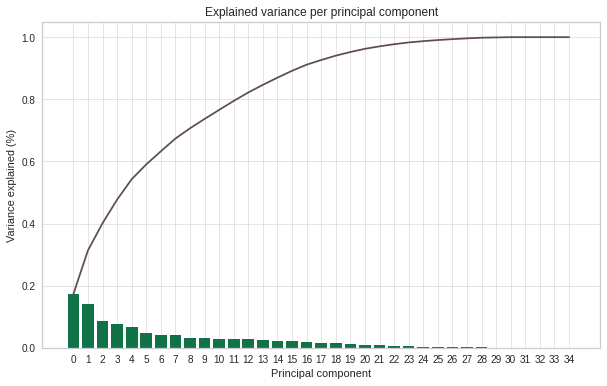

In [ ]:
# Scree plot (variance explained by each principal component)
num_components=len(pca.explained_variance_ratio_)
ind = np.arange(num_components)
vals = pca.explained_variance_ratio_
cumvals = np.cumsum(vals)

plt.figure(figsize=(10,6))

ax = sns.barplot(ind, vals, palette=starbucks[:1], ci=None)
ax2 = sns.lineplot(ind, cumvals, color=starbucks[1], ci=None)
ax.grid(b=True, which='major', linewidth=0.5)

ax.set_xlabel("Principal component")
ax.set_ylabel("Variance explained (%)")
plt.title('Explained variance per principal component');

In [ ]:
cum_expl_var_ratio = np.cumsum(pca.explained_variance_ratio_)
num_components = len(cum_expl_var_ratio[cum_expl_var_ratio <= 0.8])

# rerun PCA with components that explain 80% of the variance
pca = PCA(num_components).fit(customers_scaled)
X_pca = pca.transform(customers_scaled)
X_pca = pd.DataFrame(X_pca)

np.cumsum(pca.explained_variance_ratio_)

array([0.17314538, 0.31373335, 0.40114049, 0.47706088, 0.54288056,
       0.59044116, 0.6326669 , 0.67356134, 0.70668946, 0.73670467,
       0.7659675 , 0.79475156])

## Clustering

### K-means

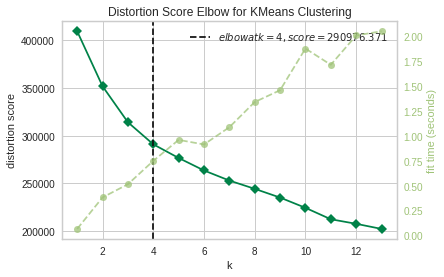

In [ ]:
# elbow method
kelbow_visualizer(KMeans(), X_pca, k=(1,14));

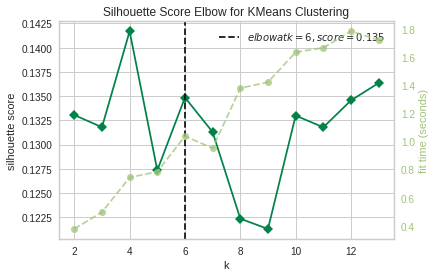

In [ ]:
# silhouette method
kelbow_visualizer(KMeans(), X_pca, k=(2,14), metric='silhouette');

In [ ]:
model = KMeans(n_clusters=4, random_state=28).fit(X_pca)
kmeans_clusters = model.predict(X_pca)

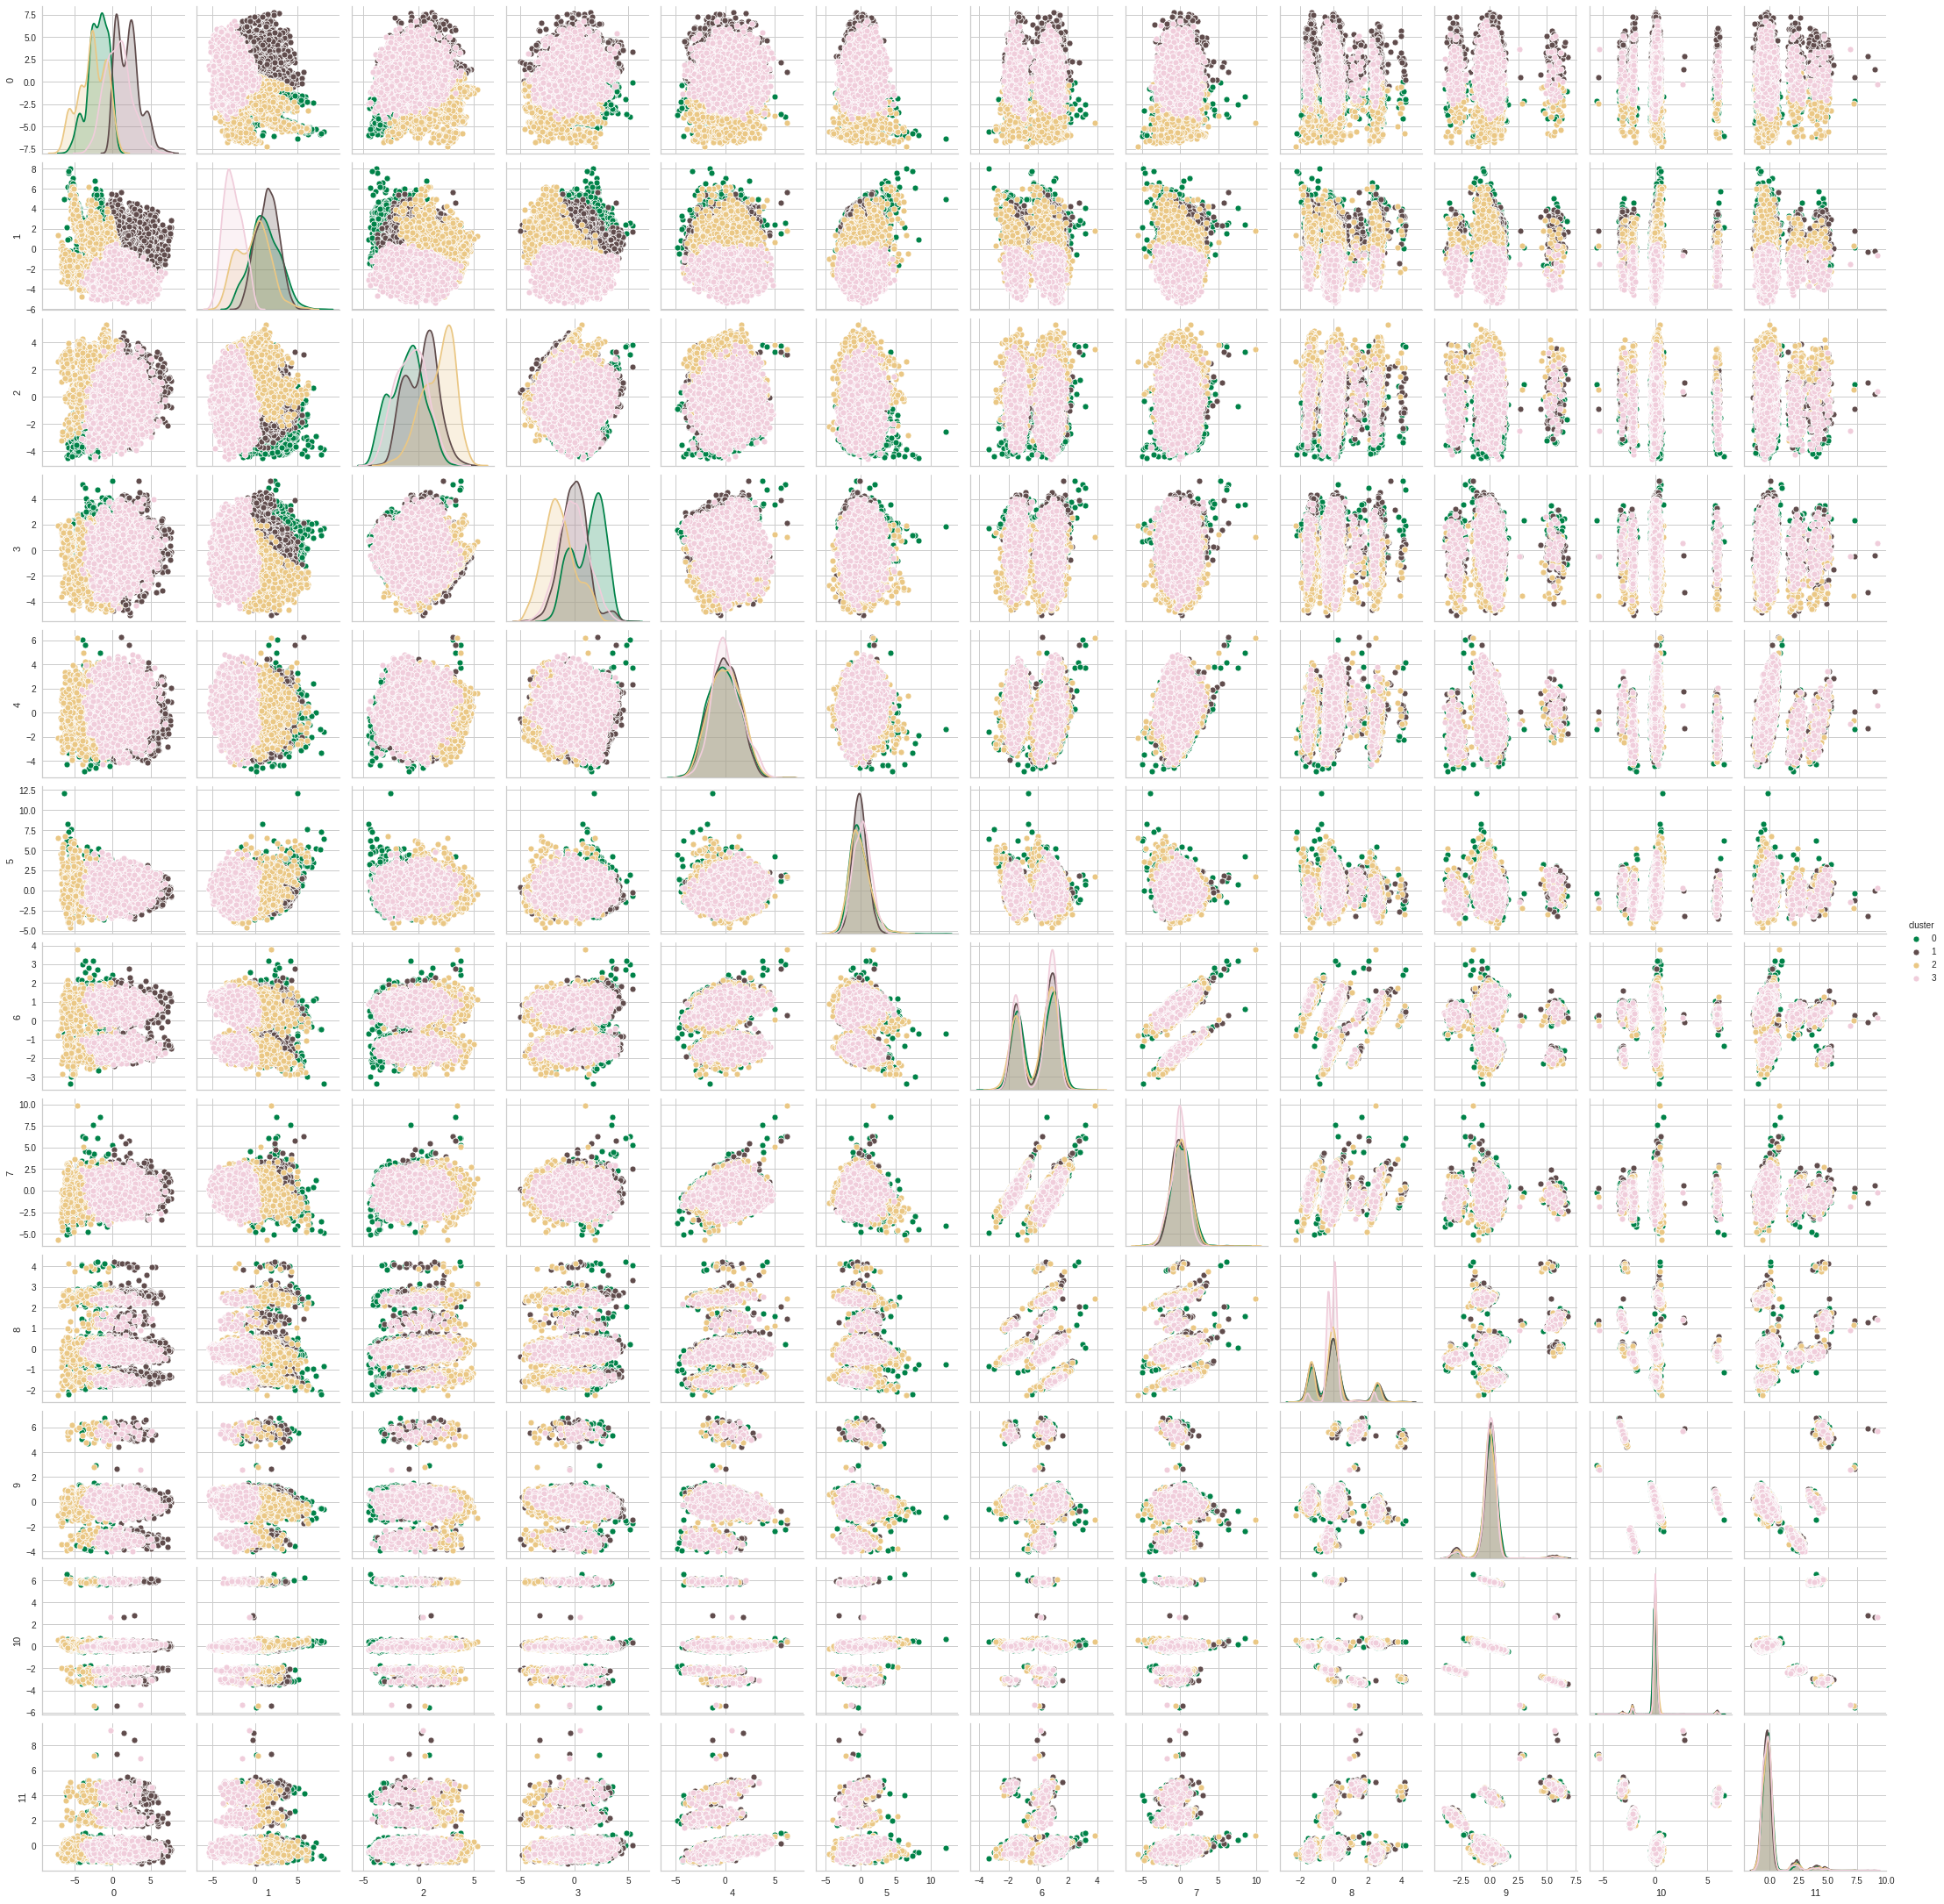

In [ ]:
df = X_pca.copy()
df['cluster'] = kmeans_clusters
sns.pairplot(df, hue='cluster')

### DBSCAN

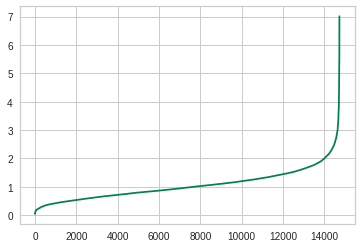

In [ ]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X_pca)
distances, indices = nbrs.kneighbors(X_pca)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [ ]:
model =  DBSCAN(eps=2.5, min_samples=150)
dbscan_clusters = model.fit_predict(X_pca)

print("Number of clusters:", len(np.unique(dbscan_clusters)))

Number of clusters: 5


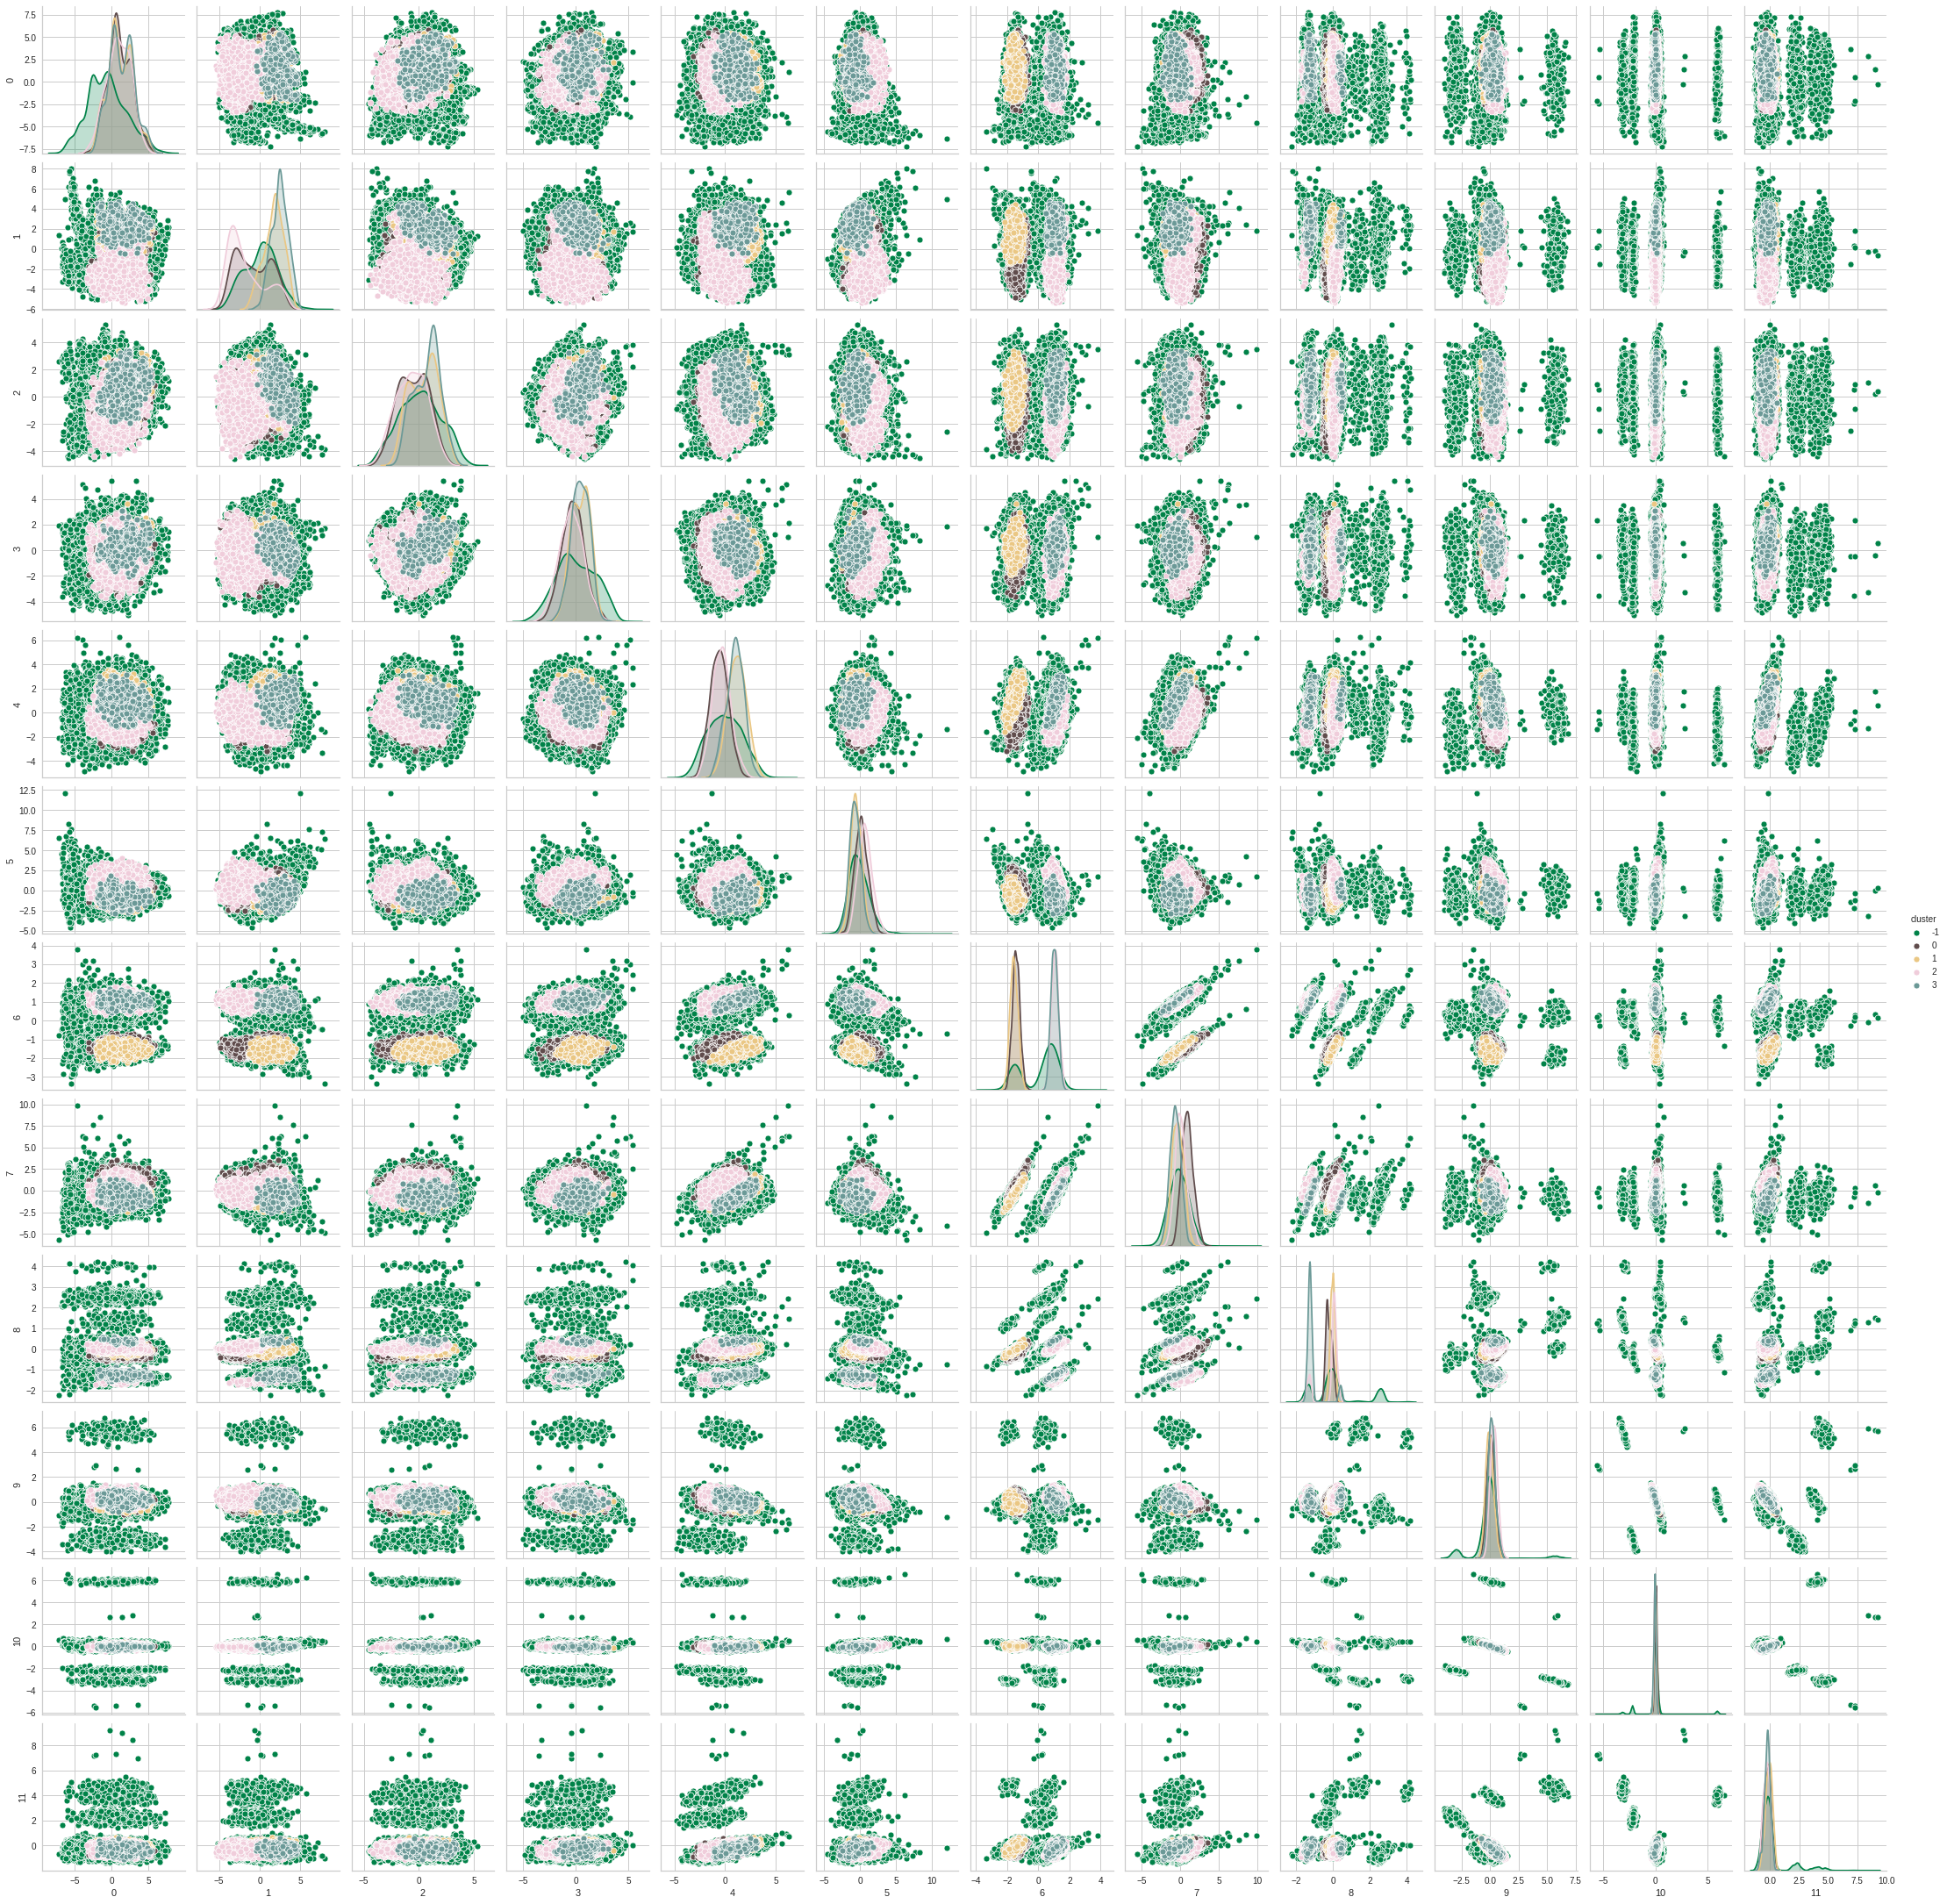

In [ ]:
df = X_pca.copy()
df['cluster'] = dbscan_clusters
sns.pairplot(df, hue='cluster')

## Evaluation

### K-means

In [ ]:
df = customers.copy().reset_index()
df['cluster'] = kmeans_clusters
df = df.melt(id_vars=['person', 'cluster'])
df = df.query('cluster != -1').groupby(['cluster', 'variable']).mean().reset_index()
df.head()

cluster        variable      value
0        0             age  55.812262
1        0        bogo_cnt   1.362135
2        0         bogo_cr   0.790767
3        0         bogo_vr   0.979723
4        0  difficulty_avg   6.954892

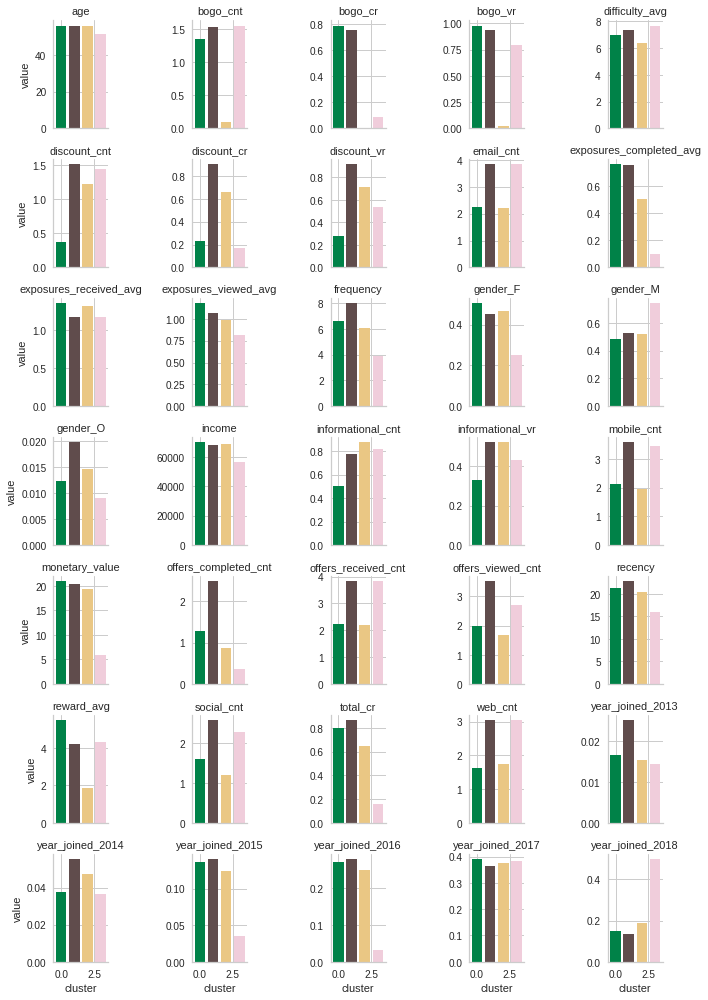

In [ ]:
g = sns.FacetGrid(df, col='variable', hue='cluster', palette=starbucks, col_wrap=5, height=2, sharey=False)
g = g.map(plt.bar, 'cluster', 'value').set_titles("{col_name}");

#### Segment 1
Customers in this segment receive regular **BOGO offers**, and practically no discount offers. These BOGO offers involve **more valuable rewards** than for customers in other segments.

Their frequency and average order value are not unusual, which suggests these customers are **conditioned to BOGOs**, and we might have to continue sending them regular offers to keep their patronage.

**BOGOs convert really well** with customers in this segment, so this is a great lever in times when we need to quickly generate additional sales.

#### Segment 2
Customers in this segment **receive a higher than average number of offers**, and **convert really well** for both BOGOs and discounts. Demographically, a higher than average share of these customers selected their **gender as "Other"**.

Their average order value is not unusual, in line with the average, but their **frequency is above average**, probably as a result of the regular offers they receive and act on.

This is another segment we can target to quickly generate additional sales.

#### Segment 3
Customers in this segment receive **no BOGO offers**. They do get occasional discount offers, on which they convert about average, as well as slightly more informational messages than other customers.

These customers have about average frequency and average order value, and would likely continue to buy at Starbucks even if we stopped sending them offers.

#### Segment 4
Customers in this segment receive **regular offers**, which they **open, but never convert**.

Demographically, they are predominantly male, and lower than average income. They also visit Starbucks less frequently, and make smaller average purchases.

Given the low LTV and low conversion rates for this group, we would be best to avoid targeting them in our marketing.

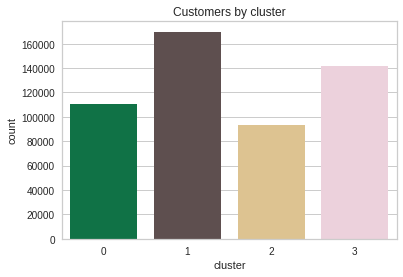

In [ ]:
# plot total number of customers per cluster
df = customers.copy().reset_index()
df['cluster'] = kmeans_clusters
df = df.melt(id_vars=['person', 'cluster'])
df.head()

ax = sns.countplot(x='cluster', data=df)
ax.set_title('Customers by cluster');